# DCGANs (Deep Convolutional Generative Adversarial Network )

Deep Convolutional Generative Adversarial Network DCGAN is an architecture in which both the generator and the discriminator are based on deep convolutional neural networks. The Generator is based on transpose convolutions and the Discriminator is based on regular convolutions.



<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/DCGAN.png" width=1000>

A generative adversarial network (GAN) is a class of machine learning frameworks . Two neural networks contest with each other in a game. Given a training set, this technique learns to generate new data with the same statistics as the training set. For example, a GAN trained on photographs can generate new photographs that look at least superficially authentic to human observers, having many realistic characteristics.

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/discri.png" width=1000>


The core idea of a GANs is based on the “indirect” training through the discriminator, which itself is also being updated dynamically. This basically means that the generator is not trained to minimize the distance to a specific image, but rather to fool the discriminator. This enables the model to learn in an unsupervised manner.

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/gan1.01.png" width=1000>

Fashion-MNIST is a dataset of Zalando’s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot



<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/gans.png" width=600>

In [1]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,Flatten,Dropout
from tensorflow.keras.layers import Reshape,Conv2DTranspose,LeakyReLU

In [3]:
# Normalize Images
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32)/255.0
X_test = X_test.astype(np.float32) /255.0

4422102/4422102 [==============================] - 1s 0us/step


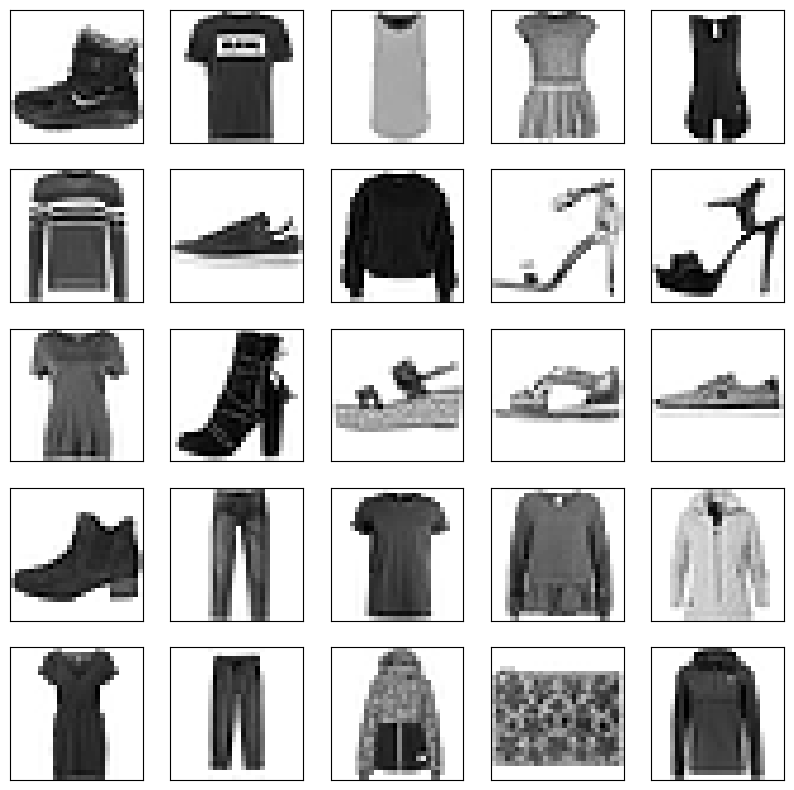

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i],cmap=plt.cm.binary)
plt.show()

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.


- To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
- For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/gan1.1.png" width=1000>


**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
Use batchnorm in both the generator and the discriminator.
Remove fully connected hidden layers for deeper architectures.
Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
Use LeakyReLU activation in the discriminator for all layers.


<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/dcgan10.png" width=850>

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/dcgan11.png" width=1000>

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/gan1.2.png" width=600>


In [5]:
## Create function for plotting

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [7]:
BATCH_SIZE = 32
NUM_FEATURES = 100
EPOCHS = 10

In [8]:
#Generator
## Start with a Flatten number of pixels

generator = Sequential(name="generator")

generator.add(Dense(7*7*128, input_shape = [NUM_FEATURES]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64,(5,5),(2,2), padding = 'same',activation = 'selu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1,(5,5),(2,2), padding = 'same',activation = 'tanh'))
## output 28x28x1
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                         

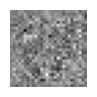

In [9]:
noise = tf.random.normal(shape=[1,NUM_FEATURES])
generated_image = generator(noise, training=False)
show(generated_image,1)

In [10]:
generated_image.shape

TensorShape([1, 28, 28, 1])

generates a random noise tensor and then feeds it into a generator model to produce a synthetic image. The generator is not updated during this process, as indicated by training=False. The exact details of what the generator does and how it's implemented would be in the code for the generator

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/dcgan13.png" width=1000>

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/dcgan12.png" width=600>


In [11]:
#Discriminator
discriminator = Sequential(name="discriminator")

discriminator.add(Conv2D(64, (5,5),(2,2), padding='same', input_shape=[28,28,1]))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5,5), (2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())

discriminator.add(Dense(1, activation='sigmoid')) #Fake or True
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [12]:
decision = discriminator(generated_image)
print(decision) # Fake or True output of the discriminator

tf.Tensor([[0.50141066]], shape=(1, 1), dtype=float32)


### Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [13]:
seed = tf.random.normal(shape=[BATCH_SIZE,100])

discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False

## GAN (GENERATOR+DISCRIMINATOR)
gan = Sequential([generator, discriminator],name='GAN')

gan.compile(loss = 'binary_crossentropy', optimizer='rmsprop') # Fake or Real?

In [14]:
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 28, 28, 1)         840705    
                                                                 
 discriminator (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


Training Loop:

- The outer loop iterates over the specified number of epochs.
The inner loop iterates over batches of real images from the dataset.
- Random noise is generated (noise) and passed through the generator to produce synthetic images (generated_images).
- Real and generated images are concatenated along the first axis to create the input for the discriminator (X_fake_and_real).
- Labels (y1 and y2) are created for training the discriminator and the GAN.
-The discriminator is trained on the combined real and generated images with corresponding labels (y1).
- The generator is trained through the GAN by fixing the discriminator's weights and updating the generator's weights using generated noise and labels (y2).
- Image generation and saving are done at the end of each epoch.

In [15]:
def plot_losses(discriminator_losses, generator_losses, epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(discriminator_losses)), discriminator_losses, label='Discriminator Loss')
    plt.plot(np.arange(len(generator_losses)), generator_losses, label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Discriminator and Generator Losses over Epochs')
    plt.show()

def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers

    discriminator_losses = []
    generator_losses = []

    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images,X_batch], axis=0)
            y1= tf.constant([[0.]]*batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real,y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable =False
            d_loss = discriminator.train_on_batch(X_fake_and_real, y1)
            discriminator_losses.append(d_loss)
            gan.train_on_batch(noise, y2)
            g_loss = gan.train_on_batch(noise, y2)
            generator_losses.append(g_loss)
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs,seed)

    # Plot the losses after training
    plot_losses(discriminator_losses, generator_losses, epochs)

In [16]:
X_train_dcgan = X_train.reshape(-1, 28,28,1)*2. -1.
X_train_dcgan.shape

(60000, 28, 28, 1)

In [17]:
#prepare data to feed the gan network
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

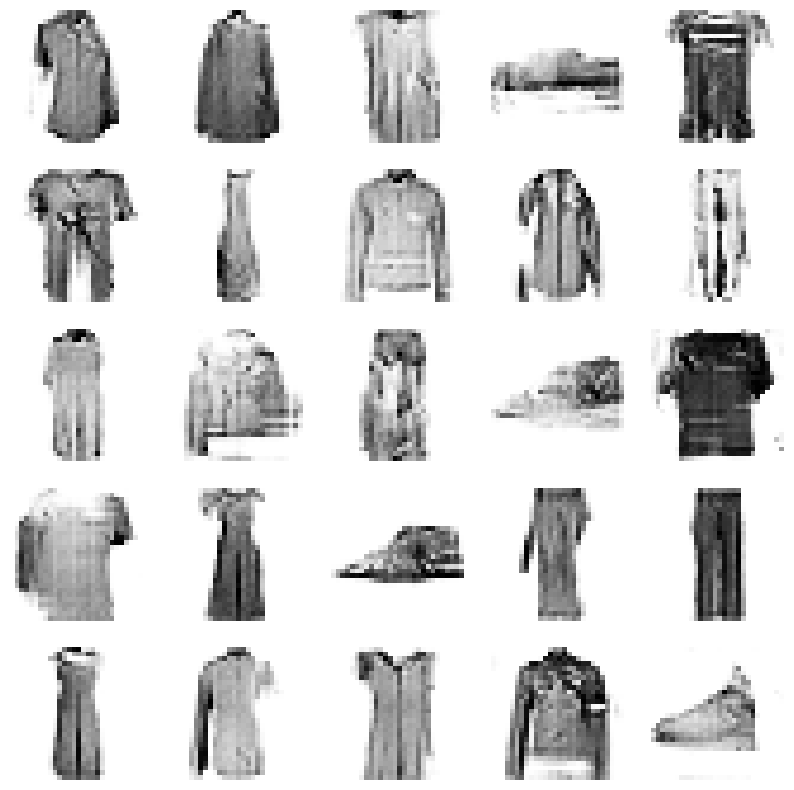

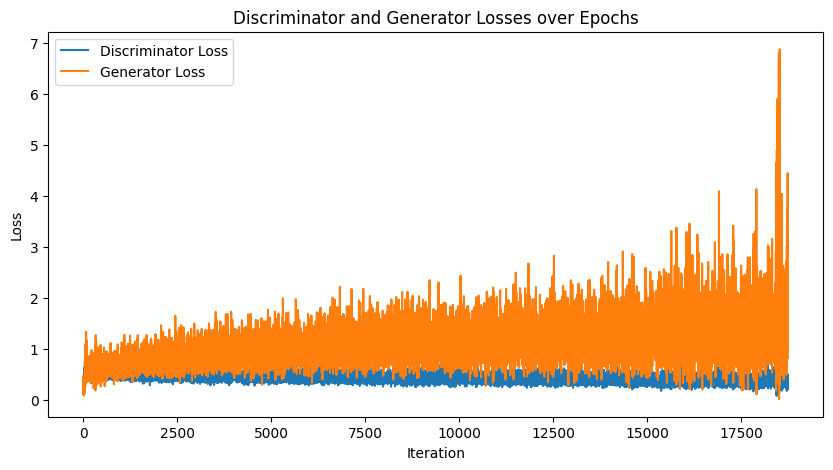

CPU times: user 16min 31s, sys: 1min 29s, total: 18min 1s
Wall time: 16min 43s


In [ ]:
%%time
train_dcgan(gan,
            dataset,
            BATCH_SIZE,
            NUM_FEATURES,
            epochs=EPOCHS
            )

##  Generate Synthetic Images with DCGAN

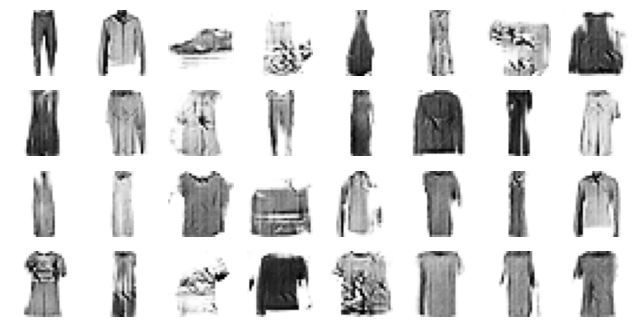

In [ ]:
noise = tf.random.normal(shape=[BATCH_SIZE, NUM_FEATURES])
generated_images = generator(noise)
show(generated_images,8)

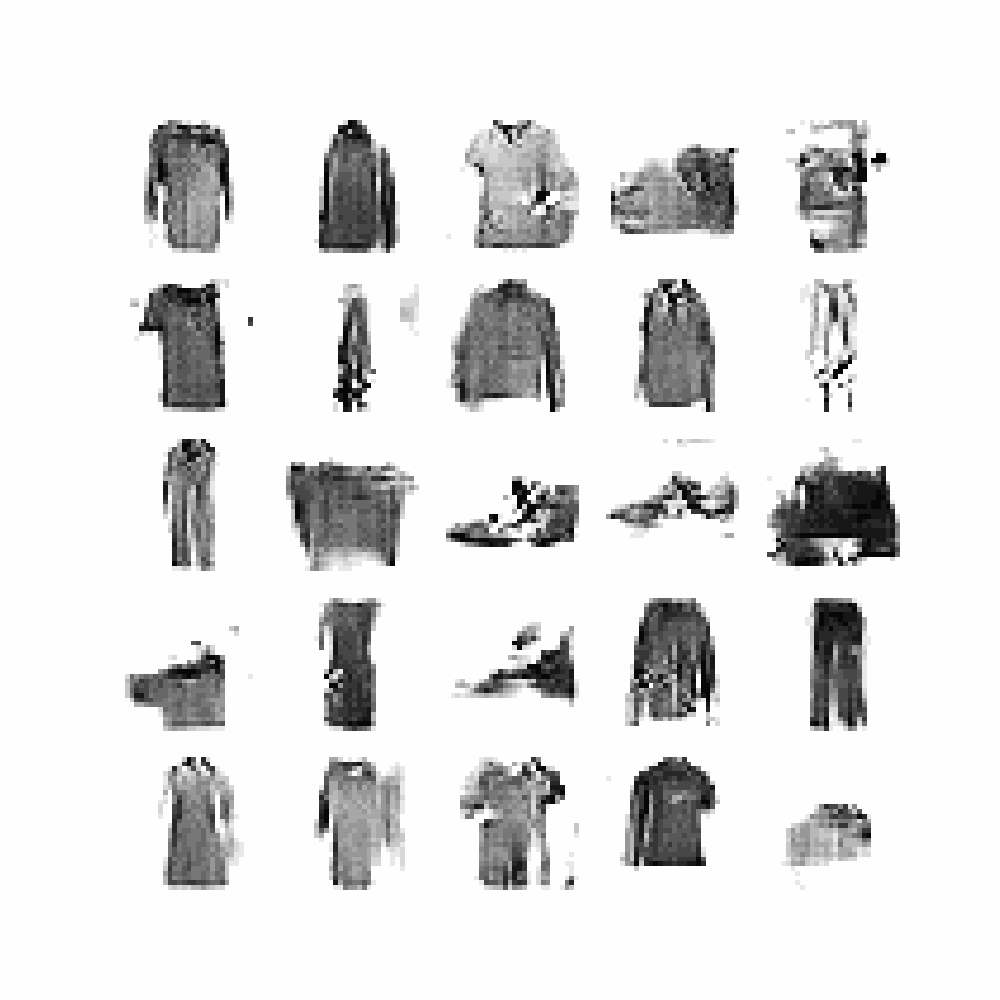

In [ ]:
import imageio.v2 as imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(filename=anim_file)

# Have Fun with DCGAN 😅

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/ganmeme.jpg" width=500>

## Final Consideration
DCGANs are a type of generative model that has shown remarkable success in generating realistic images. Here are some of the best and most common use cases:

### Image Generation:
**Synthetic Image Generation:**
DCGANs are widely used to generate synthetic images that closely resemble real images from a given dataset. This can be useful for creating diverse datasets for training machine learning models when the real data is limited.

**Artistic Content Creation:**
DCGANs can be used to generate artistic and creative content, such as paintings, designs, or other visually appealing images.

### Data Augmentation:

**Image Augmentation:**
DCGANs can augment existing datasets by generating new variations of images. This can be particularly useful in computer vision tasks where having a larger and more diverse dataset can lead to better model generalization.
Style Transfer:

**Image-to-Image Translation:**
DCGANs can be used for style transfer, transforming images from one style to another. For example, converting satellite images to maps or transforming photographs into the style of famous artists.
Super-Resolution:

**Image Super-Resolution:**
DCGANs can be adapted for super-resolution tasks, generating high-resolution images from lower-resolution inputs. This is useful in applications where detailed images are required, such as in medical imaging or surveillance.
Anomaly Detection:

**Anomaly Detection in Images:**
DCGANs can be used for detecting anomalies or outliers in images by learning the normal patterns of the training data. Any deviation from these learned patterns can be flagged as an anomaly.
Image-to-Image Translation:

**Domain Adaptation:**
DCGANs can be employed for domain adaptation, translating images from one domain to another. For instance, converting images from day to night or from one season to another.
Conditional Image Generation:

**Conditional Generation:**
DCGANs can be extended to conditional GANs (cGANs) by conditioning the generator on additional information. This allows the generation of specific types of images based on given constraints or input conditions.

## Differencies from DIFFUSION MODELS
Deep Convolutional Generative Adversarial Networks (DCGANs) and diffusion models are two distinct approaches to generative modeling, each with its own set of principles and techniques. Here's a brief overview of the key differences between DCGANs and diffusion models:

###Architecture and Training:
**DCGANs:** DCGANs are a type of generative model based on the adversarial training paradigm. They consist of a generator and a discriminator network trained simultaneously through adversarial training. The generator aims to generate realistic data, while the discriminator tries to distinguish between real and generated samples.
**Diffusion Models:** Diffusion models, on the other hand, operate by modeling the process of data diffusion. They iteratively transform a known distribution (e.g., a simple Gaussian distribution) into the target distribution (the data distribution) through a series of diffusion steps. Training involves learning the parameters that govern these diffusion steps.

###Generation Process:
**DCGANs:** DCGANs generate samples by feeding random noise into the generator, which then produces synthetic data. The training process involves adjusting the generator and discriminator to improve the quality of generated samples over time.
**Diffusion Models:** Diffusion models generate samples through a diffusion process where noise is gradually added to the data. The model learns the dynamics of how the noise is added, and the final state of the diffusion process represents the generated sample.

###Sampling Complexity:
**DCGANs:** Sampling from a DCGAN is relatively straightforward. You generate random noise and pass it through the generator to obtain a sample.
**Diffusion Models:** Sampling from diffusion models is typically more involved. It often requires a multi-step process, simulating the diffusion steps iteratively until a sample is generated.

###Objective Function:
**DCGANs:** DCGANs use adversarial training with a generator loss and a discriminator loss. The generator aims to minimize the discriminator's ability to distinguish between real and generated samples.
**Diffusion Models:** Training diffusion models involves maximizing the likelihood of the observed data given the model. This is often done through a denoising score matching objective, where the model learns to match the score (gradient of the log-likelihood) of the data distribution.

###Applications:
**DCGANs:** DCGANs are commonly used for tasks like image generation, style transfer, and data augmentation. They are prevalent in computer vision and have been successful in creating realistic-looking images.
**Diffusion Models:** Diffusion models have been applied to image generation, density estimation, and denoising tasks. They have shown promise in generating high-quality samples and capturing complex data distributions.